# Using the DeepMIMO Dataset with Sionna

In this example, you will learn how to use the ray-tracing based DeepMIMO dataset. A MISO single-user downlink transmission is considered.

[DeepMIMO](https://deepmimo.net/) is a generic dataset that enables a wide range of machine/deep learning applications for MIMO systems. It takes as input a set of parameters (such as antenna array configurations and time-domain/OFDM parameters) and generates MIMO channel realizations, corresponding locations, etc., based on these parameters and on a ray-tracing scenario selected [from those available in DeepMIMO](https://deepmimo.net/scenarios/).

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [The DeepMIMO Dataset](#The-DeepMIMO-Dataset)
* [The DeepMIMO Generator](#The-DeepMIMO-Generator)
* [MISO Single-User Downlink](#MISO-Single-User-Downlink)
* [Evaluation](#Evaluation)
* [The DeepMIMO License and Citation](#License-and-Citation)

## GPU Configuration and Imports

In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import os

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Load the required Sionna components
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers
from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber

## The DeepMIMO Dataset

DeepMIMO provides multiple [scenarios](https://deepmimo.net/scenarios/) that one can select from. In this example, we use the O1 scenario with the carrier frequency set to 60 GHz (O1_60). To run this example, please download the "O1_60" data files [from this page](https://deepmimo.net/scenarios/o1-scenario/). The downloaded zip file should be extracted into a folder, and the parameter `DeepMIMO_params['dataset_folder']` should be set to point to this folder.

To use DeepMIMO with Sionna, the DeepMIMO dataset first needs to be generated. The generated DeepMIMO dataset contains channel realizations for different locations of the users and basestations. The layout of the O1 scenario is shown in the figure below. 

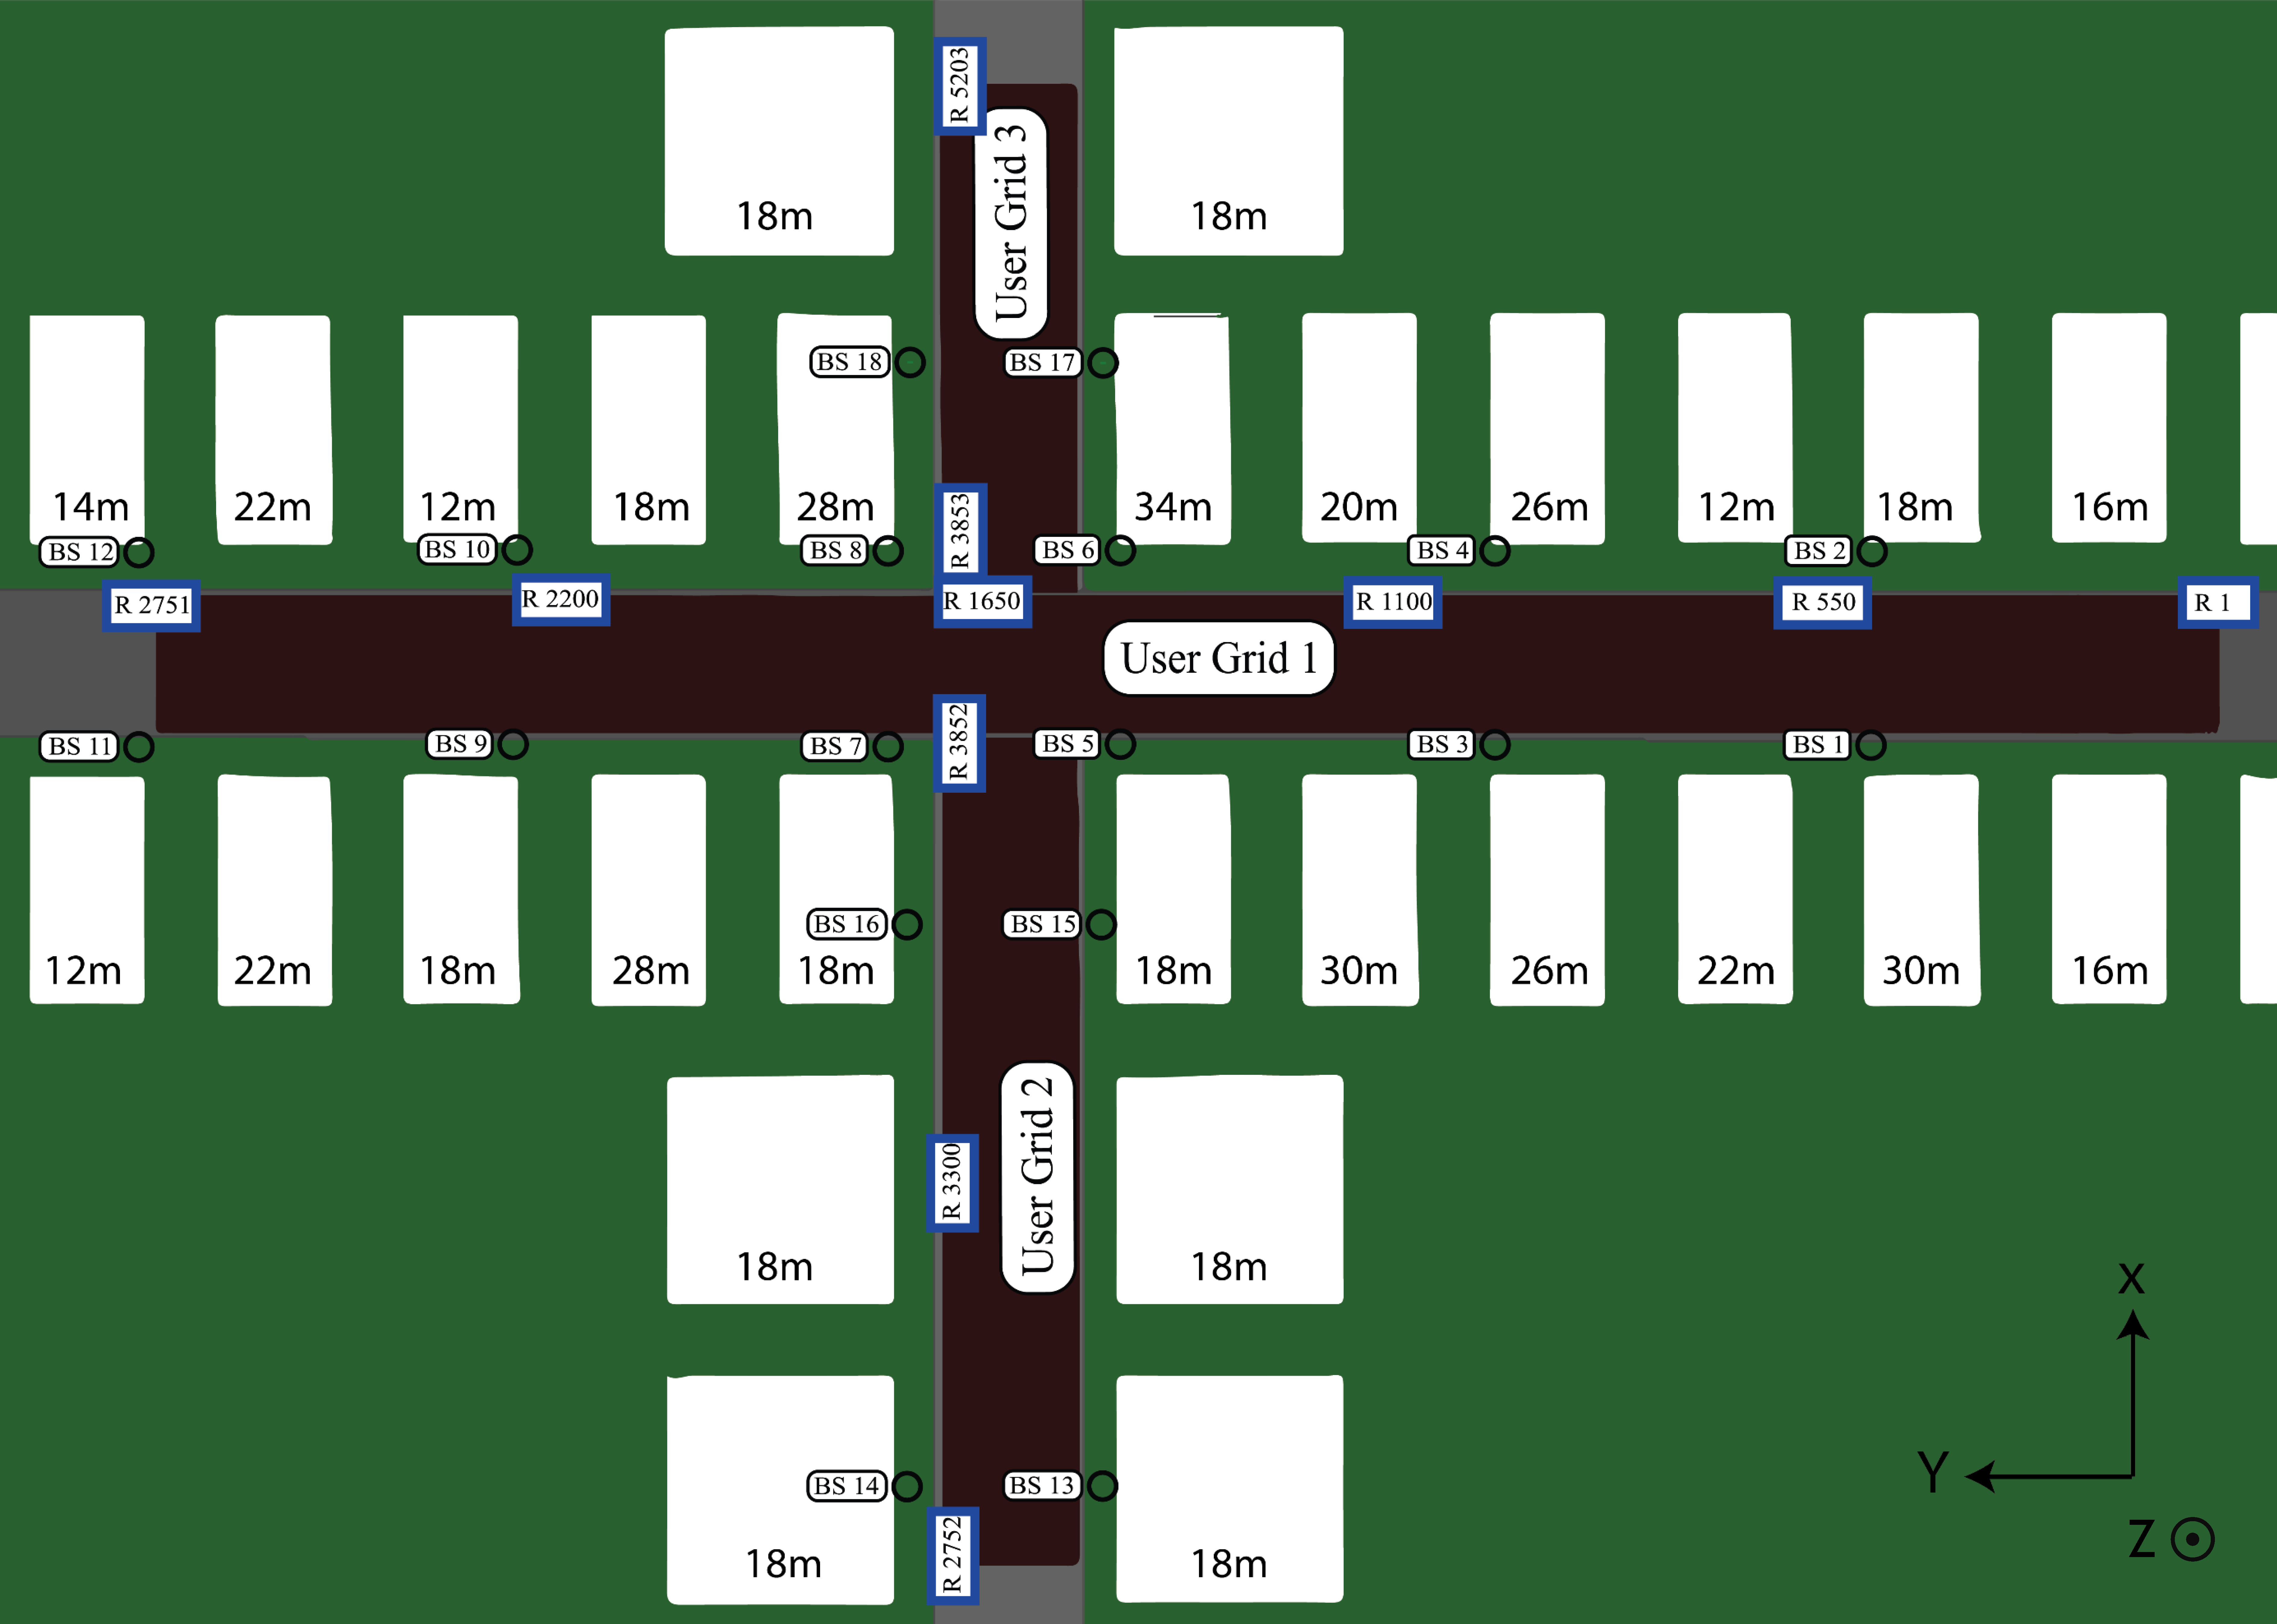

In this example, we generate a dataset that consists of channel realizations for the links from the basestation 6 to the users located on the rows 500 to 550. Each of these rows consists of 181 user locations, resulting in $51 \times 181 = 9231$ basestation-user channels.

The antenna arrays in the DeepMIMO dataset are defined through the x-y-z axes. In the following, the basestation is equipped with a uniform linear array of 16 elements spread over the x-axis. The users are each equipped with a single antenna. These parameters can be adjusted by editing the code below.

**Note:** To install DeepMIMO, execute

In [3]:
!pip install DeepMIMO

In [4]:
import DeepMIMO

# Channel generation
DeepMIMO_params = DeepMIMO.default_params() # Load the default parameters
DeepMIMO_params['dataset_folder'] = r'./scenarios' # Path to the downloaded scenarios
DeepMIMO_params['scenario'] = 'O1_60' # DeepMIMO scenario
DeepMIMO_params['num_paths'] = 10 # Maximum number of paths
DeepMIMO_params['active_BS'] = np.array([6]) # Basestation indices to be included in the dataset

# Selected rows of users, whose channels are to be generated.
DeepMIMO_params['user_row_first'] = 500 # First user row to be included in the dataset
DeepMIMO_params['user_row_last'] = 550 # Last user row to be included in the dataset

# Configuration of the antenna arrays
DeepMIMO_params['bs_antenna']['shape'] = np.array([16, 1, 1]) # BS antenna shape through [x, y, z] axes
DeepMIMO_params['ue_antenna']['shape'] = np.array([1, 1, 1]) # UE antenna shape through [x, y, z] axes

# The OFDM_channels parameter allows choosing between the generation of channel impulse
# responses (if set to 0) or frequency domain channels (if set to 1).
# It is set to 0 for this simulation, as the channel responses in frequency domain
# will be generated using Sionna.
DeepMIMO_params['OFDM_channels'] = 0

# Generates a DeepMIMO dataset
DeepMIMO_dataset = DeepMIMO.generate_data(DeepMIMO_params)


Basestation 6

UE-BS Channels


Generating channels: 100%|██████████| 9231/9231 [00:00<00:00, 17302.55it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 2031.14it/s]


### Visualization of the dataset

To provide a better understanding of the user and basestation locations, we next visualize the locations of the users, the first active row of users (row 500) and basestation 6.

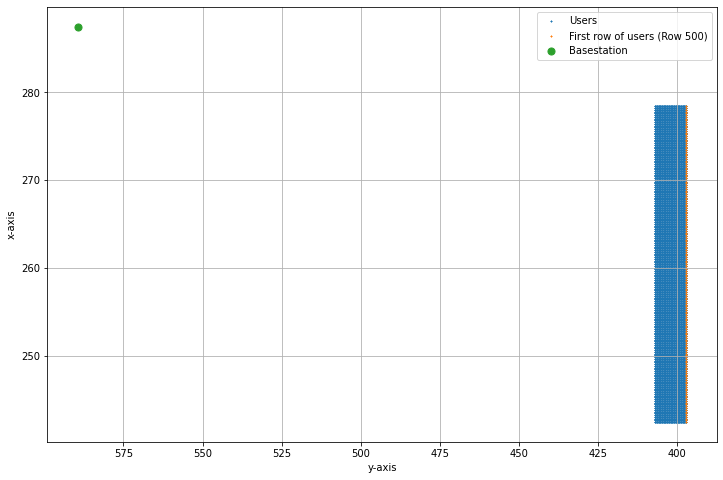

In [5]:
plt.figure(figsize=(12,8))

## User locations
active_bs_idx = 0 # Select the first active basestation in the dataset
plt.scatter(DeepMIMO_dataset[active_bs_idx]['user']['location'][:, 1], # y-axis location of the users
         DeepMIMO_dataset[active_bs_idx]['user']['location'][:, 0], # x-axis location of the users
         s=1, marker='x', c='C0', label='Users')
# First 181 users correspond to the first row
plt.scatter(DeepMIMO_dataset[active_bs_idx]['user']['location'][0:181, 1],
         DeepMIMO_dataset[active_bs_idx]['user']['location'][0:181, 0],
         s=1, marker='x', c='C1', label='First row of users (Row 500)')

## Basestation location
plt.scatter(DeepMIMO_dataset[active_bs_idx]['location'][1],
         DeepMIMO_dataset[active_bs_idx]['location'][0],
         s=50.0, marker='o', c='C2', label='Basestation')

plt.gca().invert_xaxis() # Invert the x-axis to align the figure with the figure above
plt.ylabel('x-axis')
plt.xlabel('y-axis')
plt.grid()
plt.legend();

## The DeepMIMO Generator

The DeepMIMO Python package provides a Sionna-compliant channel impulse response generator. 

A generator is instantiated for a given DeepMIMO dataset, and user and basestation location indices for which the channels are to be generated:

`DeepMIMOGenerator(DeepMIMO_dataset, bs_idx, ue_idx)`.

If values for `ue_idx` and `bs_idx` are not given, then channel realizations are randomly selected from the links between the first basestation and all users. In this example, the channel realizations will be randomly chosen from the links between the basestation 6 and the 9231 available user locations.

**Note:** `ue_idx` and `bs_idx` sets the links from which the channel realizations are drawn. For instance, if `ue_idx = [0, 1]` and `bs_idx = [2, 3]`, the generator then outputs random channel samples from the 4 realizations formed by the combination of the third and fourth basestations with the first and second users.

The generator assumes basestations are transmitters and users are receivers. Uplink channels can be generated using (transpose) reciprocity.

### Random Sampling of Multi-User Channels

To use the generator for multi-user channels, one can set `ue_idx` to a 2D matrix of size $($ #of samples $\times$ #of users $)$. For instance, `ue_idx = np.array([[0, 1 ,2], [1, 2, 3]])` generates $($# of basestations $\times$ 3 users $)$ channels with 2 data samples from each basestation to the users `[0, 1, 2]` and `[1, 2, 3]`, respectively.

When considering multiple basestations, `bs_idx` can be set to a 2D numpy matrix of shape $($ # of samples $\times$ # of basestations $)$. For instance, `bs_idx = np.array([[0, 1], [2, 3], [4, 5]])` generates $($ 2 basestations $\times$ # of users $)$ channels by stacking the data of the channels from the basestations `[0, 1]`, `[2, 3]`, and `[4, 5]` to the users, respectively.

In order to randomly sample channel realizations from all the available user locations considering `num_tx` users, one may set `ue_idx` as in the following cell.

In [6]:
from DeepMIMO import DeepMIMOGenerator

# Number of receivers for the Sionna model.
# MISO is considered here.
num_rx = 1

# The number of UE locations in the generated DeepMIMO dataset
num_ue_locations = len(DeepMIMO_dataset[0]['user']['channel']) # 9231
# Pick the largest possible number of user locations that is a multiple of ``num_rx``
ue_idx = np.arange(num_rx*(num_ue_locations//num_rx))
# Optionally shuffle the dataset to not select only users that are near each others
np.random.shuffle(ue_idx)
# Reshape to fit the requested number of users
ue_idx = np.reshape(ue_idx, [-1, num_rx])

DeepMIMO_generator = DeepMIMOGenerator(DeepMIMO_dataset, ue_idx=ue_idx)

## MISO Single-User Downlink

In the following cell, we define a Sionna model implementing the end-to-end link.

In [7]:
class LinkModel(tf.keras.Model):
    def __init__(self,
                 DeepMIMO_generator,
                 carrier_frequency,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 60e3,
                 batch_size = 64
                ):
        super().__init__()

        self._batch_size = batch_size
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices

        # CIRDataset to parse the dataset
        self._CIR = sionna.channel.CIRDataset(DeepMIMO_generator,
                                              self._batch_size,
                                              DeepMIMO_generator.num_rx,
                                              DeepMIMO_generator.num_rx_ant,
                                              DeepMIMO_generator.num_tx,
                                              DeepMIMO_generator.num_tx_ant,
                                              DeepMIMO_generator.num_paths,
                                              DeepMIMO_generator.num_time_steps)

        # System parameters
        self._carrier_frequency = carrier_frequency
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 76
        self._num_ofdm_symbols = 14
        self._num_streams_per_tx = DeepMIMO_generator.num_rx
        self._dc_null = False
        self._num_guard_carriers = [0, 0]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 4
        self._coderate = 0.5

        # Setup the OFDM resource grid and stream management
        self._sm = StreamManagement(np.ones([DeepMIMO_generator.num_rx, 1], int), self._num_streams_per_tx)
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=DeepMIMO_generator.num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Components forming the link

        # Codeword length
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        # Number of information bits per codeword
        self._k = int(self._n * self._coderate)

        # OFDM channel
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        self._ofdm_channel = sionna.channel.GenerateOFDMChannel(self._CIR, self._rg, normalize_channel=True)
        self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        # Transmitter
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        self._zf_precoder = ZFPrecoder(self._rg, self._sm, return_effective_channel=True)

        # Receiver
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="lin_time_avg")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function
    def call(self, batch_size, ebno_db):

        # Transmitter
        b = self._binary_source([self._batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        # Generate the OFDM channel
        h_freq = self._ofdm_channel()
        # Precoding
        x_rg, g = self._zf_precoder([x_rg, h_freq])

        # Apply OFDM channel
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        y = self._channel_freq([x_rg, h_freq, no])

        # Receiver
        h_hat, err_var = self._ls_est ([y, no])
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)

        return b, b_hat

## Evaluation
We evaluate the setup with different $E_b/N_0$ values to obtain BLER curves.

In [8]:
sim_params = {
              "ebno_db": np.linspace(-7, -5, 10),
              "cyclic_prefix_length" : 0,
              "pilot_ofdm_symbol_indices" : [2, 11],
              }
batch_size = 64
model = LinkModel(DeepMIMO_generator=DeepMIMO_generator,
                  carrier_frequency=DeepMIMO_params['scenario_params']['carrier_freq'],
                  cyclic_prefix_length=sim_params["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=sim_params["pilot_ofdm_symbol_indices"])
ber, bler = sim_ber(model,
                    sim_params["ebno_db"],
                    batch_size=batch_size,
                    max_mc_iter=100,
                    num_target_block_errors=100)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -7.0 | 1.2670e-01 | 1.0000e+00 |       29580 |      233472 |          128 |         128 |         5.1 |reached target block errors
   -6.778 | 8.7467e-02 | 9.9219e-01 |       20421 |      233472 |          127 |         128 |         0.2 |reached target block errors
   -6.556 | 4.7963e-02 | 9.3750e-01 |       11198 |      233472 |          120 |         128 |         0.2 |reached target block errors
   -6.333 | 1.1901e-02 | 5.8854e-01 |        4168 |      350208 |          113 |         192 |         0.3 |reached target block errors
   -6.111 | 1.8203e-03 | 1.7969e-01 |        2125 |     1167360 |          115 |         640 |         0.9 |reached target block errors
   -5.889 | 2.1982e-04 | 2.6483e-02 |        1514 |     6887424 |

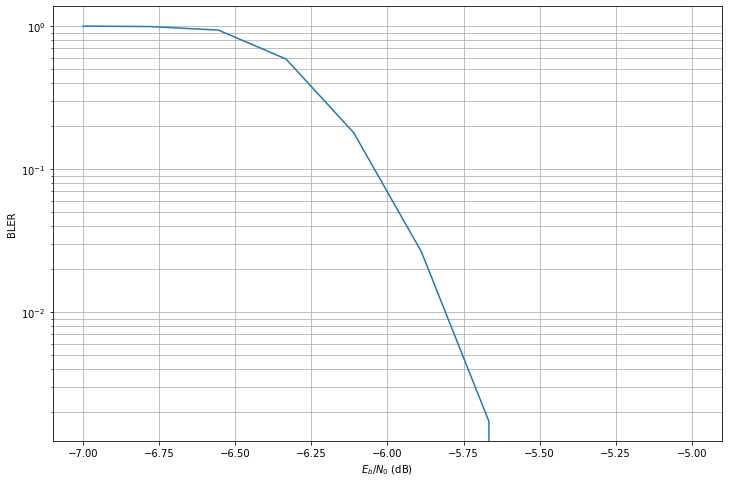

In [9]:
plt.figure(figsize=(12,8))
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.semilogy(sim_params["ebno_db"], bler)

## License and Citation

The DeepMIMO dataset is licensed under the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-nc-sa/4.0/). If you in any way use the DeepMIMO dataset for research that results in publications, please cite both the original article and the Remcom Wireless InSite website:
> - A. Alkhateeb, “[DeepMIMO: A Generic Deep Learning Dataset for Millimeter Wave and Massive MIMO Applications](https://arxiv.org/pdf/1902.06435.pdf),” in Proc. of Information Theory and Applications Workshop (ITA), San Diego, CA, Feb. 2019.
> - Remcom, Wireless InSite, “http://www.remcom.com/wireless-insite”